# Modelling 12 Technical Indicators With Machine Learning Predictions

Ref: [CodeTraining video: "Technical Indicators Comparison Using Machine Learning In Python"](https://www.youtube.com/watch?v=tNFnACpzxVw&list=PLwEOixRFAUxZO-WTGS1rJ4ijvkUePWg_-&index=5)
* Src: [EURUSD_ALL_TA_ML.ipynb](https://drive.google.com/file/d/1dI9NwRHLc9MiEgRYqn44-6aGXskBmOKY/view)

In [15]:
import os
import sys

sys.path.append("..")
os.chdir("..")

In [16]:
import pandas as pd
from dotenv import load_dotenv

from src.utils.common.constants import STOCKS_CURATED_TABLE_NAME
from src.utils.common.stock_duck_db_conn import StockDuckDbConn

load_dotenv("config/.env")

ticker = "CBA.AX"

df: pd.DataFrame = None
with StockDuckDbConn().current_conn as conn:
    df = conn.sql(f"""
        SELECT * FROM {STOCKS_CURATED_TABLE_NAME}
        WHERE ticker = ?
    """, params=[ticker]).to_df()

#Check if NA values are in data
df=df[df['volume']!=0]
df.reset_index(drop=True, inplace=True)
# df.isna().sum()
# df.tail()

In [ ]:
#Target flexible way
pipdiff = 200*1e-1 #for TP - amended for this dataset TODO check if correct
SLTPRatio = 2 #pipdiff/Ratio gives SL
def mytarget(barsupfront, df1):
    length = len(df1)
    high = list(df1['high'])
    low = list(df1['low'])
    close = list(df1['close'])
    open = list(df1['open'])
    trendcat = [None] * length
    for line in range (0,length-barsupfront-2):
        valueOpenLow = 0
        valueOpenHigh = 0
        for i in range(1,barsupfront+2):
            value1 = open[line+1]-low[line+i]
            value2 = open[line+1]-high[line+i]
            valueOpenLow = max(value1, valueOpenLow)
            valueOpenHigh = min(value2, valueOpenHigh)
        
            # if ( (valueOpenLow >= (pipdiff/SLTPRatio)) and (-valueOpenHigh >= (pipdiff/SLTPRatio)) ):
            # trendcat[line] = 2 # bth limits exceeded
            # elif ( (valueOpenLow >= pipdiff) and (-valueOpenHigh <= (pipdiff/SLTPRatio)) ):
            # trendcat[line] = 3 #-1 downtrend
            # elif ( (valueOpenLow <= (pipdiff/SLTPRatio)) and (-valueOpenHigh >= pipdiff) ):
            # trendcat[line] = 1 # uptrend
            # elif ( (valueOpenLow <= (pipdiff/SLTPRatio)) and (-valueOpenHigh <= (pipdiff/SLTPRatio)) ):
            # trendcat[line] = 0 # no trend
            # elif ( (valueOpenLow >= (pipdiff/SLTPRatio)) and (-valueOpenHigh <= (pipdiff/SLTPRatio)) ):
            # trendcat[line] = 5 # light trend down
            # elif ( (valueOpenLow <= (pipdiff/SLTPRatio)) and (-valueOpenHigh >= (pipdiff/SLTPRatio)) ):
            # trendcat[line] = 4 # light trend up

            # trends are defined in ascending order for trends, but the classifier requires 0-based categories:
            # 0 = downtrend
            # 1 = no clear trend
            # 2 = uptrend

            if ( (valueOpenLow >= pipdiff) and (-valueOpenHigh <= (pipdiff/SLTPRatio)) ):
                trendcat[line] = 0 # downtrend
                break
            elif ( (valueOpenLow <= (pipdiff/SLTPRatio)) and (-valueOpenHigh >= pipdiff) ):
                trendcat[line] = 2 # uptrend
                break
            else:
                trendcat[line] = 1 # no clear trend
            
    return trendcat

<Axes: >

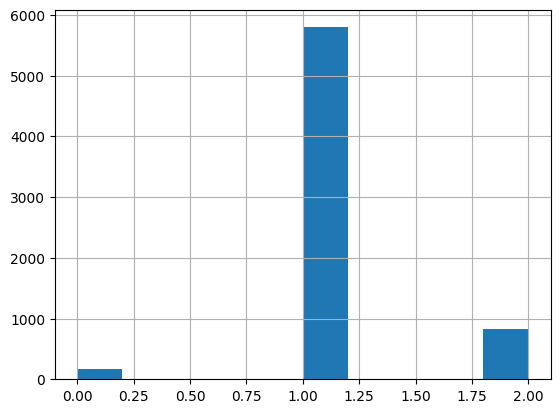

In [18]:
df['Target'] = mytarget(20, df)
df['Target'].hist()
#df.tail(20)
# df['Target'] = df['Target'].fillna(0).astype(int)

In [19]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df.tail()

,ticker,date,open,high,low,close,volume,RSI,CCI,AO,...,DMP_16,DMN_16,STOCHk_14_3_3,STOCHd_14_3_3,STOCHh_14_3_3,STOCHRSIk_16_14_3_3,STOCHRSId_16_14_3_3,WPR,load_time,Target
6792,CBA.AX,2024-09-13,139.266110,139.440929,136.877035,137.566559,1991893,59.402482,-4763.266070,6.744152,...,0.741945,0.485675,63.481377,69.950276,-6.468899,7.855795,19.395757,-38.232385,2026-01-03 11:27:27.312875,2.0
6793,CBA.AX,2024-10-01,131.108274,131.108274,128.855147,129.496124,1744679,39.520479,-2512.840131,-4.346319,...,0.506905,0.828255,11.583621,10.332131,1.251490,4.222023,2.814682,-94.745198,2026-01-03 11:27:27.312875,2.0
6794,CBA.AX,2024-10-08,130.496438,132.108588,129.661229,131.079147,1587040,45.190462,-2168.702120,-4.963787,...,0.575187,0.719305,15.968954,14.849226,1.119729,16.247345,12.351061,-77.751992,2026-01-03 11:27:27.312875,2.0
6795,CBA.AX,2024-10-18,137.809369,138.731995,137.382065,138.731995,3075255,63.370514,-3936.885800,0.477163,...,0.738234,0.470543,98.082409,94.072141,4.010268,100.000000,96.145785,0.000000,2026-01-03 11:27:27.312875,2.0
6796,CBA.AX,2024-11-05,140.188757,140.237304,138.683437,139.703171,1165546,58.616578,-8221.532304,3.256382,...,0.611737,0.453082,82.002584,79.286269,2.716315,42.785518,46.616326,-9.647501,2026-01-03 11:27:27.312875,1.0


In [20]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, log_loss

attributes = ['RSI', 'CCI', 'AO', 'MOM', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'ATR',
       'BOP', 'RVI', 'DMP_16', 'DMN_16', 'STOCHk_14_3_3', 'STOCHd_14_3_3',
       'STOCHRSIk_16_14_3_3', 'STOCHRSId_16_14_3_3', 'WPR']

# attributes = ['MACDs_12_26_9', 'ATR', 'DMP_16']

x = df[attributes]
y = df['Target']

y.unique()

train_pct_index = int(0.7 * len(x))
X_train, X_test = x[:train_pct_index], x[train_pct_index:]
y_train, y_test = y[:train_pct_index], y[train_pct_index:]

model = XGBClassifier()
model.fit(X_train, y_train)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)
print('****Train Results****')
print("Accuracy: {:.4%}".format(acc_train))
print('****Test Results****')
print("Accuracy: {:.4%}".format(acc_test))

****Train Results****
Accuracy: 100.0000%
****Test Results****
Accuracy: 94.2647%


In [21]:
from sklearn.metrics import confusion_matrix, classification_report

matrix_train = confusion_matrix(y_train, pred_train)
matrix_test = confusion_matrix(y_test, pred_test)

print(matrix_train)
print(matrix_test)

report_train = classification_report(y_train, pred_train)
report_test = classification_report(y_test, pred_test)

print(report_train)
print(report_test)
#choices = [2, 0, -1, +1]
##choices = [2, 0, 3, +1]
print(model.get_booster().feature_names)

[[ 117    0    0]
 [   0 4066    0]
 [   0    0  574]]
[[  39    9    2]
 [   8 1680   42]
 [   5   51  204]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       117
         1.0       1.00      1.00      1.00      4066
         2.0       1.00      1.00      1.00       574

    accuracy                           1.00      4757
   macro avg       1.00      1.00      1.00      4757
weighted avg       1.00      1.00      1.00      4757

              precision    recall  f1-score   support

         0.0       0.75      0.78      0.76        50
         1.0       0.97      0.97      0.97      1730
         2.0       0.82      0.78      0.80       260

    accuracy                           0.94      2040
   macro avg       0.85      0.85      0.85      2040
weighted avg       0.94      0.94      0.94      2040

['RSI', 'CCI', 'AO', 'MOM', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'ATR', 'BOP', 'RVI', 'DMP_16', 'DMN_16', 'STOCHk_1

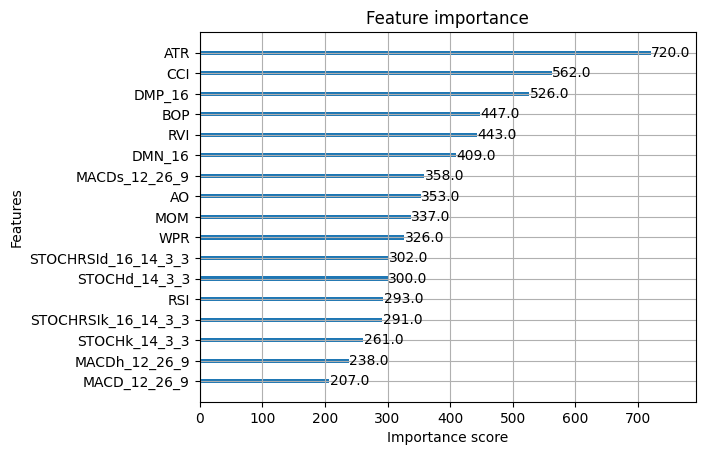

['RSI', 'CCI', 'AO', 'MOM', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'ATR', 'BOP', 'RVI', 'DMP_16', 'DMN_16', 'STOCHk_14_3_3', 'STOCHd_14_3_3', 'STOCHRSIk_16_14_3_3', 'STOCHRSId_16_14_3_3', 'WPR']


In [22]:
from matplotlib import pyplot
from xgboost import plot_importance
from sklearn.feature_selection import SelectFromModel
#pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
#plot feature importance
plot_importance(model)
pyplot.show()
print(model.get_booster().feature_names)